# CLUSTERS

In [1]:
import numpy as np
import json
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

In [2]:
import configparser
Config = configparser.ConfigParser()
Config.read("Config.conf")

['Config.conf']

In [3]:
def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1

## Cargando datos

In [4]:
# Cargamos file
footprint= ConfigSectionMap("f2")['footprints']

data = pd.read_csv(footprint, low_memory=False)
data.head()

,CO_ID,YEAR,WEEK,PROFILE_ID,SIZE,D0T0P0,D0T0P1,D0T0P2,D0T0P3,D0T0P4,...,D6T3P28,D6T3P29,D6T3P30,D6T3P31,D6T3P32,D6T3P33,D6T3P34,D6T3P35,D6T3P36,D6T3P37
0,10002698,2018,18,0,3.7290,0.0000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10002698,2018,19,1,3.9590,0.2110,0.2078,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002698,2018,20,2,2.8130,0.0000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10002698,2018,21,3,5.3620,0.0002,0.0000,0.0,0.0,0.0001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10002698,2018,22,4,0.7254,0.0006,0.0000,0.0,0.0,0.0006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Creamos parte de la cabecera que es dinamica de acuerdo al número de mccgs

In [5]:
title = ''
for i in range(7):                # numero de dias
    for j in range(4):            # numero de turnos
        for k in range(38):       # numero de planes
            title = title+';'+'D'+str(i)+'T'+str(j)+'P'+str(k)
title = title+'\n'

## Funciones de Apoyo (clusters)

**process_footprint**: guarda en una lista los resultados de **bench_k_means** de cada K y recibe como parametros:
1. **data**: los datos que seran clusterizados
2. **tests**: ingresamos el rango de los posibles K, en este caso tomamos: **{1,2,3,...,len(data)}**
3. **log**: True para imprimir el momento actual y el k que estamos procesando


Para cada cliente que tiene  S'=< U(1),U(2),...,U(m)>  con m<=n

Entrada      Entrada S'
             Salida F = {f1,f2,...,fo}    con o<=m

**Procesamos los footprints (U)**

    para i de 1 a u-longitud         
    Usando "MiniBatchKMeans" obtenemos la inercia
        k = [1,2,3,...,u-longitud]
        inercia = [?,?,?,...,?]
   **salida: s1:{k,inercia}**
  
 <br>
  
**MiniBatchKMeans**

In [6]:
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}  #  Creamos una lista vacia
    # Probamos para cada K
    for k in tests:
        if k<=len(data):
            if log:
                print("%s: processing %s"%(datetime.datetime.now(),k))
            
            # Cargamos en K(indice k) = los resultados de "MiniBatchKMeans"
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)
            
    return K





**bench_k_means** recibe como entrada el modelo **MiniBatchKMeans**
<div>Obtenemos:</div>
1. inercia: suma de las distancias al cuadrado de cada objeto del Cluster a su centroide.
2. duracion
3. estimador



In [7]:
def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

Mejor k    **compute_best_k** recibe como parametros:
1. **x**: los datos que seran clusterizados
2. **y**: inercias
3. **occurrencies**: numero de elementos, posibles Ks
3. **plot**: True para plotear SSE's elbow graph 
3. **points**: numero de puntos a interpólar
3. **sf**:  factor used to smooth



    Generamos 1000 puntos con el comportamiento de s1 con la funcion "UnivariateSpline"
Donde: tenemos 'k,inercia'

    salida: s_final = get_change_point(k',inercia')           # MEJOR K
         

In [8]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    
    if len(x)<5:
        b_k = max(1, round(np.sqrt(occurrencies/2)))
        if plot:
            import pylab
            pylab.plot(x,y)
            pylab.scatter(x[b_k],y[b_k],s=20, marker='o')
            pylab.text(x[b_k],y[b_k],"bestK %s" %(b_k))
            return b_k,pylab

        return b_k
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

Definimos **get_change_point**: 
<div>Busca encontrar el punto ideal en los datos ingresados.</div>
 
**get_change_point**

    Entrada: x,y (vector)                                         # indice y valor de los puntos interpolados
    PARA i de o a length(x ó y)
        C = closest_point_on_segment(A={xo,yo}, B={xf,yf}, X={xi,yi})    # salida C = {c1, c2}
        d = raiz_2[ (c1-xi)^2 + (c2-yi)^2 ]
        SI d > max_d
            max_d = d
            index = 1
        FIN
    FIN
    Salida: index
FIN 


In [9]:
def get_change_point(x, y):
    """
         Elección del mejor K
         :: param x: lista de valores de K
         :: param y: lista de valores de SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

definimos **closest_point_on_segment**
<div>Retorna el </div>

**closest_point_on_segment**

    Entrada: A={xo,yo}, B={xf,yf}, X={xi,yi} (listas)    # el primer, ultimo e i-esimo punto interpolado
    delta_x = xf - xo
    delta_y = yf - yo
    
    SI delta_x y delta_y == 0
        Salida = X
    FIN
    
    U = [(xi-x0) * delta_y] + [(yi-yo) * delta_x]  
        / ( delta_x ^ 2 + delta_y ^ 2 )
    
    SI U < 0
        Salida = A      
    SINO_SI U > 1
        Salida = B      
    SINO
        cp_x = xo + u * delta_x
        cp_y = yo + u * delta_y
        Salida = { cp_x , cp_y }
    FIN
FIN   

In [10]:
def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	

# Clusters Individuales (f)

Para cada cliente que tiene  S'=< U(1),U(2),...,U(m)>     con m<=n

Entrada      
1. Entrada S'
2. Salida F = {f1,f2,...,fo}    con o<=m      
            

**process_data** 

    Entrada: datos a clusterizar
        obtienen la lista de Ks y su inercia
        selecciona el mejor k
    Salida: centroides y etiquetas

In [11]:
def process_data(to_cluster):
    K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1))
    
    # Choose k
    x=list(K.keys())
    y=[K[k]['inertia'] for k in K]
    best_k=compute_best_k(x,y,len(to_cluster))
    
    print(str(contador)+' => clustering: '+str(clientes[n_cliente])+' len data: '+str(len(data))+" best k: "+str(best_k))

    # clustering
    if best_k==1:
        #to few records
        cluster_centers = [np.average(to_cluster,axis=0)]
        labels = [0]*len(to_cluster)  
    else:
        cluster_centers = K[best_k]['estimator'].cluster_centers_
        labels = K[best_k]['estimator'].labels_

    return cluster_centers,labels


In [12]:
# Extraemos la lista de clientes sin repetir
clientes =  data.groupby('CO_ID').CO_ID.count().index
clientes

Int64Index([10002698, 10012082, 10017768, 10018071, 10018341, 10029507,
            10030093, 10031033, 10033129, 10033196,
            ...
            10200009, 10200496, 10210056, 10212096, 10212748, 10226765,
            10227470, 10227479, 10233354, 10235940],
           dtype='int64', name='CO_ID', length=125)

In [13]:
# choosen files
individual_clusters = ConfigSectionMap("f3")['ic_cluster']
individual_labels= ConfigSectionMap("f3")['ic_label'] 

    
# Numero de filas del archivo
f=open(footprint)
num_rows = len(f.readlines())-1
f.close()

f=open(footprint)
fw=open(individual_clusters,'w')        # File de Centroides
fw2=open(individual_labels,'w')         # File de Labels
fw.write('CO_ID;INDIVIDUAL_CLUSTER'+title)                # Escribimos la cabecera (Centroides)
fw2.write('CO_ID;YEAR;WEEK;INDIVIDUAL_CLUSTER'+title)     # Escribimos la cabecera (Labels)
f.readline()        # Saltamos la primera fila (cabecera)

footprints_clustered=0 ##
footprints_clusters=0  ##

n_cliente=0           # Indica el nuemro del cliente que estamos reccoriendo
contador = 0          # Indica en número de registro en el que estamos
data=[]             # buffer vacio

# Reading individual footprint (line to line)
for row in f:
    row=row.strip().split(',') # leemos cada elemento de la linea parseada por ","
    uid=row[0]
    year=row[1]
    week=row[2]
    size=float(row[4])
    profile=np.array([float(el) for el in row[5:]])  # Lo que deberiamos ingresar al modelos para clusterizar,(el cubo)

    # Individual clustering
    if uid==str(clientes[n_cliente]): # Para cada fila donde los "uid" son iguales 
        data.append(((uid,year,week),profile))     # Añadimos a buffer "data"
        contador+=1                                # El número de filas leídas se incrementa en 1
    
    else: #final de cliente
        #---------------------------------------------------------------------
        # procesar data
        #---------------------------------------------------------------------
        to_cluster=[el[1] for el in data]
        temporal= process_data(to_cluster) # procesamos la data para obtener los centroides y labels
        cluster_centers_=temporal[0]
        labels_=temporal[1]

        
        #export individual centroids
        for i in np.arange(len(cluster_centers_)):
            string="%s;%s;%s\n"%(clientes[n_cliente],i,';'.join([str(el) for el in cluster_centers_[i]]))
            #uid,cluster_id,centroid
            fw.write(string)
            footprints_clusters+=1
        fw.flush()

        #export original data and labels
        for i in np.arange(len(data)):
            uid2=data[i][0]
            profile2=data[i][1]
            label2=labels_[i]
            string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
            fw2.write(string)
            footprints_clustered+=1
        fw2.flush()
        #---------------------------------------------------------------------
        #---------------------------------------------------------------------



        data=[] # buffer se vacia e inicia para un nuevo cliente
        data.append(((uid,year,week),profile))      # Añadimos a buffer "data" del nuevo cliente
        contador+=1                                 # El número de filas leídas se incrementa en 1
        n_cliente+=1                                # El índice de cliente se incrementa en 1

    if contador == num_rows:        # Para el ultimo cliente y ultima fila
        #---------------------------------------------------------------------
        # procesar data
        #---------------------------------------------------------------------
        to_cluster=[el[1] for el in data]
        temporal= process_data(to_cluster)  # procesamos la data para obtener los centroides y labels
        cluster_centers_=temporal[0]
        labels_=temporal[1]

        #export individual centroids
        for i in np.arange(len(cluster_centers_)):
            string="%s;%s;%s\n"%(uid,i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
            fw.write(string)
            footprints_clusters+=1
        fw.flush()

        #export original data and labels
        for i in np.arange(len(data)):
            uid2=data[i][0]
            profile2=data[i][1]
            label2=labels_[i]
            string="%s;%s;%s;%s;%s\n" %(uid2[0],uid2[1],uid2[2],label2
                                                        ,';'.join([str(el) for el in profile2]))#uid,year,week,cluster_id,profile
            fw2.write(string)
            footprints_clustered+=1
        fw2.flush()
        #---------------------------------------------------------------------
        #---------------------------------------------------------------------

fw.close()
fw2.close() 
print('Done')            
    

5 => clustering: 10002698 len data: 5 best k: 3
9 => clustering: 10012082 len data: 4 best k: 1
14 => clustering: 10017768 len data: 5 best k: 2
19 => clustering: 10018071 len data: 5 best k: 4
24 => clustering: 10018341 len data: 5 best k: 2
29 => clustering: 10029507 len data: 5 best k: 3
34 => clustering: 10030093 len data: 5 best k: 2
39 => clustering: 10031033 len data: 5 best k: 2
44 => clustering: 10033129 len data: 5 best k: 2
49 => clustering: 10033196 len data: 5 best k: 4
54 => clustering: 10042282 len data: 5 best k: 3
58 => clustering: 10048445 len data: 4 best k: 1
62 => clustering: 10054582 len data: 4 best k: 1
67 => clustering: 10058864 len data: 5 best k: 3
72 => clustering: 10059021 len data: 5 best k: 3
77 => clustering: 10059215 len data: 5 best k: 2
82 => clustering: 10059420 len data: 5 best k: 3
87 => clustering: 10062626 len data: 5 best k: 3
91 => clustering: 10063491 len data: 4 best k: 1
96 => clustering: 10065472 len data: 5 best k: 2
101 => clustering: 100

# Clusters Colectivos (g)

2018-10-29 19:17:55.095084: processing 1
2018-10-29 19:17:55.133255: processing 2
2018-10-29 19:17:55.174792: processing 3
2018-10-29 19:17:55.224992: processing 4
2018-10-29 19:17:55.276809: processing 5
2018-10-29 19:17:55.329197: processing 6
2018-10-29 19:17:55.394131: processing 7
2018-10-29 19:17:55.465149: processing 8
2018-10-29 19:17:55.528635: processing 9
2018-10-29 19:17:55.598252: processing 10
2018-10-29 19:17:55.677577: processing 11
2018-10-29 19:17:55.757312: processing 12
2018-10-29 19:17:55.845897: processing 13
2018-10-29 19:17:55.949998: processing 14
2018-10-29 19:17:56.047300: processing 15
2018-10-29 19:17:56.159255: processing 16
2018-10-29 19:17:56.278347: processing 17
2018-10-29 19:17:56.390470: processing 18
2018-10-29 19:17:56.510956: processing 19
2018-10-29 19:17:56.636506: processing 20
2018-10-29 19:17:56.761337: processing 21
2018-10-29 19:17:56.887285: processing 22
2018-10-29 19:17:57.021036: processing 23
2018-10-29 19:17:57.158337: processing 24
2

/home/jkn/anaconda3/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


59


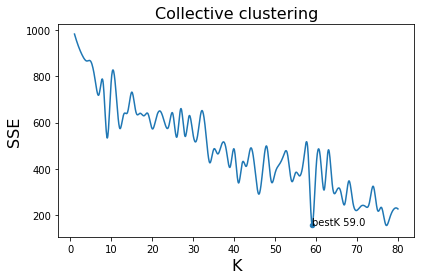

In [14]:

# choosen files
individual_clusters = ConfigSectionMap("f3")['ic_cluster']
individual_labels= ConfigSectionMap("f3")['ic_label'] 
collective_clusters = ConfigSectionMap("f3")['cc_cluster']
collective_labels= ConfigSectionMap("f3")['cc_label'] 

    
f=open(individual_clusters)   #  uid,cluster_id,profile
f.readline()                  #  Saltamos una linea

data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
    
if len(to_cluster) >= 80:
    tests=np.arange(1,80+1)
else:
    tests=np.arange(1,len(to_cluster)+1)
# tests=list(tests)+list(np.arange(50,150,5))
K=process_footprint(to_cluster,tests,log=True)
# K=process_footprint(to_cluster,np.arange(1,len(to_cluster)+1),log=True)

import pickle
# pickle.dump( K, open( "%s.models.p" %(file), "wb" ) )
    
# Choose K for global clustering 
# %matplotlib inline
x=sorted(K.keys())
y=[K[k]['inertia'] for k in x]
best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=1000)

print(best_k)
# best_k=2 #a mano
plt.title("Collective clustering",fontsize=16)
plt.ylabel("SSE",fontsize=16)
plt.xlabel("K",fontsize=16)
plt.tight_layout()
#plt.show()
#pylab.savefig('%s.png' %(raw_data),dpi=200)

plt.savefig("../resultados/Global_clusters_e.png",dpi = 500)

import pandas as pd
df_sse=pd.DataFrame([x,y]).T
df_sse.columns=['x','y']
#df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)

In [15]:
 # EXPORTANDO RESULTADOS
cluster_centers_=K[best_k]['estimator'].cluster_centers_
labels_=K[best_k]['estimator'].labels_
fw=open(collective_clusters,"w")
fw2=open(collective_labels,"w")
fw.write('COLLECTIVE_CLUSTER'+title)
fw2.write('CO_ID;INDIVIDUAL_CLUSTER;COLLECTIVE_CLUSTER'+title)

#export individual centroids
for j in np.arange(len(cluster_centers_)):
    string="%s;%s\n"%(j,';'.join([str(el) for el in cluster_centers_[j]])) #cluster_id,centroid
    fw.write(string)
fw.flush()

#export original data and labels
for j in np.arange(len(data)):
    uid=data[j][0]
    profile=data[j][1]
    label=labels_[j]
    string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                    ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
    fw2.write(string)
fw2.flush()

print('Done')

Done
